In [ ]:
import pandas as pd
import os
import numpy as np
import seaborn as sns 
import plotly.express as px
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.cm as cm

os.chdir("/net/trapnell/vol1/home/mdcolon/proj/morphseq")
from src.vae.auxiliary_scripts.assess_vae_results import assess_vae_results

from src.functions.embryo_df_performance_metrics import *


save_dir = "/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20250121"

model_index = 74
df_orig = pd.read_csv("/net/trapnell/vol1/home/nlammers/projects/data/morphseq/training_data/20241107_ds/SeqVAE_z100_ne150_sweep_01_block01_iter030/SeqVAE_training_2024-11-11_15-45-40/figures/embryo_stats_df.csv")

z_mu_columns = [col for col in df_orig.columns if 'z_mu' in col]    
z_mu_biological_columns = [col for col in z_mu_columns if "b" in col]



/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/9030537.1.trapnell-login.q/ipykernel_3968353/3855952120.py:20: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_orig = pd.read_csv("/net/trapnell/vol1/home/nlammers/projects/data/morphseq/training_data/20241107_ds/SeqVAE_z100_ne150_sweep_01_block01_iter030/SeqVAE_training_2024-11-11_15-45-40/figures/embryo_stats_df.csv")

# partitioning dataset by temperature

In [3]:
import pandas as pd
from sklearn.decomposition import PCA

def apply_pca_on_pert_comparisons(
    df, 
    z_mu_biological_columns, 
    pert_comparisons=None, 
    n_components=3
):
    """
    Applies PCA on a subset of the DataFrame based on specified perturbations and adds PCA components
    to the same DataFrame (rows not in 'pert_comparisons' are removed).

    Parameters:
    - df (pd.DataFrame): The original DataFrame containing the data.
    - z_mu_biological_columns (list): List of column names in df to use for PCA.
    - pert_comparisons (iterable, optional): An iterable (e.g., list) of phenotypes to include in PCA.
                                             If None, all unique phenotypes are used.
    - n_components (int, optional): Number of PCA components to compute. Default is 3.

    Returns:
    - pd.DataFrame: The filtered DataFrame (rows matching 'pert_comparisons') with added PCA columns.
    """
    # Ensure necessary columns exist
    required_columns = ['phenotype'] + z_mu_biological_columns
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        raise ValueError(f"DataFrame is missing required columns: {missing_columns}")
    
    # Set pert_comparisons to all unique phenotypes if not provided
    if pert_comparisons is None:
        pert_comparisons = df['phenotype'].unique()
        print(f"No perturbations specified. Using all available phenotypes: {list(pert_comparisons)}")
    else:
        print(f"Using specified perturbations for PCA: {pert_comparisons}")

    # Filter the DataFrame based on 'pert_comparisons'
    df = df[df['phenotype'].isin(pert_comparisons)]
    
    # If no rows remain, raise an error
    if df.empty:
        raise ValueError("No data found for the specified perturbations in pert_comparisons.")
    
    # Extract the data for PCA
    X = df[z_mu_biological_columns].values
    
    # Handle missing values if any
    if pd.isnull(X).any():
        raise ValueError("Missing values detected in z_mu_biological_columns. "
                         "Please handle them before applying PCA.")
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    pcs = pca.fit_transform(X)
    
    # Create PCA column names
    pca_columns = [f"PCA_{i+1}" for i in range(n_components)]
    
    # In-place assignment of PCA columns using a concise for loop
    # Initialize columns with NaN (optional) before assignment
    df.loc[:, pca_columns] = pd.NA
    
    for i, col in enumerate(pca_columns):
        df[col] = pcs[:, i]
    
    # Calculate Explained Variance
    explained_variance_ratio = pca.explained_variance_ratio_
    total_explained_variance = explained_variance_ratio.sum()
    
    # Print organized output
    print("\nPCA Explained Variance:")
    print("----------------------------")
    print(f"Total Explained Variance by {n_components} components: {total_explained_variance:.2%}\n")
    
    variance_data = {
        'Principal Component': pca_columns,
        'Explained Variance Ratio': [f"{ratio:.2%}" for ratio in explained_variance_ratio]
    }
    variance_df = pd.DataFrame(variance_data)
    print(variance_df.to_string(index=False))
    print("----------------------------\n")
    
    return df

In [16]:
# Specify the minimum number of snip_ids per embryo_id
pert_comparisons = ["wt", "lmx1b", "inj-ctrl"]

min_snips = 20

# Filter the DataFrame to only include embryo_id with at least `min_snips` snip_ids
df    = df_orig.groupby('embryo_id').filter(lambda x: len(x) >= min_snips)
df_30 = df[df["temperature"]==30.0]
df_22 = df[df["temperature"]==22.0]


df_30   = apply_pca_on_pert_comparisons(df_30  ,z_mu_biological_columns,pert_comparisons=pert_comparisons )
df_22   = apply_pca_on_pert_comparisons(df_22  ,z_mu_biological_columns,pert_comparisons=pert_comparisons )
df      = apply_pca_on_pert_comparisons(df_orig,z_mu_biological_columns,pert_comparisons=pert_comparisons )

Using specified perturbations for PCA: ['wt', 'lmx1b', 'inj-ctrl']


/tmp/9030537.1.trapnell-login.q/ipykernel_3968353/1512297501.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pcs[:, i]



PCA Explained Variance:
----------------------------
Total Explained Variance by 3 components: 85.35%

Principal Component Explained Variance Ratio
              PCA_1                   41.39%
              PCA_2                   33.56%
              PCA_3                   10.41%
----------------------------

Using specified perturbations for PCA: ['wt', 'lmx1b', 'inj-ctrl']


/tmp/9030537.1.trapnell-login.q/ipykernel_3968353/1512297501.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pcs[:, i]



PCA Explained Variance:
----------------------------
Total Explained Variance by 3 components: 87.44%

Principal Component Explained Variance Ratio
              PCA_1                   41.93%
              PCA_2                   33.67%
              PCA_3                   11.85%
----------------------------

Using specified perturbations for PCA: ['wt', 'lmx1b', 'inj-ctrl']

PCA Explained Variance:
----------------------------
Total Explained Variance by 3 components: 86.00%

Principal Component Explained Variance Ratio
              PCA_1                   41.85%
              PCA_2                   33.45%
              PCA_3                   10.70%
----------------------------



/tmp/9030537.1.trapnell-login.q/ipykernel_3968353/1512297501.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pcs[:, i]


# creating splines


In [14]:
import os
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.covariance import MinCovDet

# ============================
# Utility Functions
# ============================
def compute_spline_distances(spline_pts):
    """Compute cumulative distances along the spline."""
    diffs = np.diff(spline_pts, axis=0)
    seg_lengths = np.linalg.norm(diffs, axis=1)
    cumdist = np.insert(np.cumsum(seg_lengths), 0, 0.0)
    return cumdist, cumdist[-1]

def split_spline(spline_pts, k):
    """
    Split the spline into k segments based on cumulative distance.
    Returns a list of (start_pt, end_pt) tuples.
    """
    cumdist, total_dist = compute_spline_distances(spline_pts)
    segment_distances = np.linspace(0, total_dist, k+1)
    segment_indices = np.searchsorted(cumdist, segment_distances)
    segment_list = []
    for i in range(k):
        i0 = min(segment_indices[i], len(spline_pts) - 1)
        i1 = min(segment_indices[i+1], len(spline_pts) - 1)
        start_pt = spline_pts[i0]
        end_pt = spline_pts[i1]
        segment_list.append((start_pt, end_pt))
    return segment_list

def point_to_segment_distance(point, seg_start, seg_end):
    """
    Minimum distance from a 3D point to a line segment defined by seg_start, seg_end.
    """
    seg_vec = seg_end - seg_start
    pt_vec = point - seg_start
    seg_len_sq = np.dot(seg_vec, seg_vec)
    if seg_len_sq == 0.0:
        return np.linalg.norm(point - seg_start)
    t = np.dot(pt_vec, seg_vec) / seg_len_sq
    t = np.clip(t, 0.0, 1.0)
    projection = seg_start + t * seg_vec
    return np.linalg.norm(point - projection)

def assign_points_to_segments(pert_df, segments):
    """
    Assign each point to the closest segment, create a 'segment_id' column in pert_df.
    """
    points = pert_df[["PCA_1", "PCA_2", "PCA_3"]].values
    assigned_segments = []
    
    for p in points:
        min_dist = float('inf')
        seg_idx = -1
        for i, (s0, s1) in enumerate(segments):
            dist = point_to_segment_distance(p, s0, s1)
            if dist < min_dist:
                min_dist = dist
                seg_idx = i
        assigned_segments.append(seg_idx)
    
    pert_df["segment_id"] = assigned_segments
    return pert_df

def perform_robust_pca(seg_points):
    """
    Perform robust PCA using Minimum Covariance Determinant (MCD).
    Returns the principal axis (first eigenvector) or None if not enough points.
    """
    if len(seg_points) < 2:
        return None
    try:
        mcd = MinCovDet().fit(seg_points)
        cov = mcd.covariance_
        eig_vals, eig_vecs = np.linalg.eigh(cov)
        principal_axis = eig_vecs[:, np.argmax(eig_vals)]
        principal_axis /= np.linalg.norm(principal_axis)
        return principal_axis
    except:
        # Fallback to standard PCA if MCD fails
        pca = PCA(n_components=3)
        pca.fit(seg_points)
        principal_axis = pca.components_[0]
        principal_axis /= np.linalg.norm(principal_axis)
        return principal_axis

def create_spline_segments_for_df(df, pert_splines, k=50):
    """
    For each phenotype in df, finds its spline in pert_splines, splits it into k segments,
    assigns each point to a segment, performs robust PCA for each segment, and returns:
    
    1) df_augmented: original df augmented with 'segment_id'
    2) segment_info_df: columns = [
        phenotype, seg_id, segment_avg_time, segment_var_time,
        principal_axis_x, principal_axis_y, principal_axis_z,
        segment_midpoint_x, segment_midpoint_y, segment_midpoint_z,
        segment_start_x, segment_start_y, segment_start_z,
        segment_end_x, segment_end_y, segment_end_z
    ]
    3) (optionally) return pert_splines, which is often unchanged
    """
    # 1. Copy df so we don't mutate the original
    df_augmented = df.copy()
    
    # 2. We'll store per-segment info in this list of dicts
    segment_info_records = []
    
    # 3. Loop over each phenotype
    unique_phenotypes = df_augmented["phenotype"].unique()
    for pert in tqdm(unique_phenotypes, desc="Processing phenotypes"):
        # A) Extract all points for this phenotype
        pert_df = df_augmented[df_augmented["phenotype"] == pert].copy()
        if pert_df.empty:
            continue
        
        # B) Retrieve the spline points for this phenotype
        spline_data = pert_splines[pert_splines["phenotype"] == pert]
        if spline_data.empty:
            continue
        
        # Convert to NumPy
        spline_points = spline_data[["PCA_1", "PCA_2", "PCA_3"]].values
        
        # C) Split the spline
        segment_list = split_spline(spline_points, k)
        
        # D) Assign points to segments
        pert_df = assign_points_to_segments(pert_df, segment_list)
        
        # E) Update df_augmented with new segment IDs
        df_augmented.loc[pert_df.index, "segment_id"] = pert_df["segment_id"]
        
        # F) For each segment, perform robust PCA
        seg_data_dict = {}
        for seg_id in range(k):
            seg_points_df = pert_df[pert_df["segment_id"] == seg_id]
            seg_points = seg_points_df[["PCA_1", "PCA_2", "PCA_3"]].values
            
            if len(seg_points) < 2:
                principal_axis = None
            else:
                principal_axis = perform_robust_pca(seg_points)
            
            seg_start, seg_end = segment_list[seg_id]
            midpoint = 0.5 * (seg_start + seg_end)
            
            seg_data_dict[seg_id] = {
                "principal_axis": principal_axis,
                "segment_midpoint": midpoint,
                "segment_start": seg_start,
                "segment_end": seg_end,
                "segment_avg_time": seg_points_df["predicted_stage_hpf"].mean(),
                "segment_var_time": seg_points_df["predicted_stage_hpf"].var()
            }
        
        # G) Build segment_info_records
        for seg_id, info in seg_data_dict.items():
            principal_axis = info["principal_axis"]
            midpoint = info["segment_midpoint"]
            seg_start = info["segment_start"]
            seg_end = info["segment_end"]
            segment_avg_time = info["segment_avg_time"]
            segment_var_time = info["segment_var_time"]
            
            if principal_axis is None:
                px, py, pz = np.nan, np.nan, np.nan
            else:
                px, py, pz = principal_axis
            
            mx, my, mz = midpoint
            sx, sy, sz = seg_start
            ex, ey, ez = seg_end
            
            record = {
                "phenotype": pert,
                "seg_id": seg_id,
                "segment_avg_time": segment_avg_time,
                "segment_var_time": segment_var_time,
                "principal_axis_x": px,
                "principal_axis_y": py,
                "principal_axis_z": pz,
                "segment_midpoint_x": mx,
                "segment_midpoint_y": my,
                "segment_midpoint_z": mz,
                "segment_start_x": sx,
                "segment_start_y": sy,
                "segment_start_z": sz,
                "segment_end_x": ex,
                "segment_end_y": ey,
                "segment_end_z": ez
            }
            segment_info_records.append(record)
    
    # 4. Convert records to DataFrame
    segment_info_df = pd.DataFrame(segment_info_records)
    return df_augmented, segment_info_df, pert_splines

# ============================
# Main Wrapper Function
# ============================
def build_splines_and_segments(
    df,
    save_dir,
    model_index,
    LocalPrincipalCurveClass,
    comparisons=None,
    bandwidth=0.5,
    max_iter=250,
    tol=1e-3,
    angle_penalty_exp=2,
    early_stage_offset=1.0,
    late_stage_offset=3.0,
    k=50
):
    """
    1) Builds splines for each phenotype in `comparisons` using LocalPrincipalCurve
    2) Creates `df_augmented` by assigning segment IDs for each phenotype
    3) Returns `pert_splines`, `df_augmented`, and `segment_info_df`
    
    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame containing at least ["phenotype", "PCA_1", "PCA_2", "PCA_3", "predicted_stage_hpf"].
    comparisons : list
        List of phenotypes to process.
    save_dir : str
        Directory to save the spline CSV if desired.
    model_index : int
        Model index used in naming output files.
    LocalPrincipalCurveClass : class
        Reference to your LocalPrincipalCurve class (or a similar spline-fitting class).
    bandwidth : float
        Bandwidth parameter for LocalPrincipalCurve.
    max_iter : int
        Max iterations for LocalPrincipalCurve fitting.
    tol : float
        Tolerance for LocalPrincipalCurve convergence.
    angle_penalty_exp : int
        Angle penalty exponent for LocalPrincipalCurve.
    early_stage_offset : float
        Window (in hours) for selecting "early" timepoints to compute the average start point.
    late_stage_offset : float
        Window (in hours) for selecting "late" timepoints to compute the average end point.
    k : int
        Number of segments to split each spline into.

    Returns
    -------
    pert_splines : pd.DataFrame
        DataFrame containing the spline points for each phenotype.
    df_augmented : pd.DataFrame
        Original DataFrame plus a `segment_id` column.
    segment_info_df : pd.DataFrame
        Per-segment PCA info (principal_axis, midpoint, etc.).
    """
    
    # ----------------------------
    # 1. Generate a color palette
    # and Handle `comparisons` Parameter
    # ----------------------------
    if comparisons is None:
        comparisons = list(df["phenotype"].unique())
        print(f"No comparisons specified. Using all available phenotypes: {comparisons}")
    else:
        print(f"Using specified comparisons for spline building: {comparisons}")
        

    color_palette = px.colors.qualitative.Plotly
    if len(comparisons) > len(color_palette):
        extended_palette = color_palette * (len(comparisons) // len(color_palette) + 1)
    else:
        extended_palette = color_palette

    # ----------------------------
    # 2. Build Spline Data
    # ----------------------------
    print("Building spline data for each phenotype...")
    splines_records = []

    df = df[df["phenotype"].isin(comparisons)]
    
    for idx, pert in enumerate(tqdm(comparisons, desc="Creating splines for each phenotype")):
        # Filter the DataFrame for the given phenotype
        pert_df = df[df["phenotype"] == pert].copy()
        if pert_df.empty:
            # If no data points for this phenotype, skip
            continue

        # Extract PCA coordinates
        pert_3d = pert_df[["PCA_1", "PCA_2", "PCA_3"]].values
        
        # Compute average early stage point
        min_time = pert_df["predicted_stage_hpf"].min()
        early_mask = (pert_df["predicted_stage_hpf"] >= min_time) & \
                     (pert_df["predicted_stage_hpf"] < min_time + early_stage_offset)
        avg_early_timepoint = pert_df.loc[early_mask, ["PCA_1", "PCA_2", "PCA_3"]].mean().values
        
        # Compute average late stage point
        max_time = pert_df["predicted_stage_hpf"].max()
        late_mask = (pert_df["predicted_stage_hpf"] >= (max_time - late_stage_offset))
        avg_late_timepoint = pert_df.loc[late_mask, ["PCA_1", "PCA_2", "PCA_3"]].mean().values

        # Downsample for curve fitting (example: 5% for wt, 10% for others)
        if len(pert_3d) == 0:
            continue
        
        if pert == "wt":
            subset_size = max(1, int(0.05 * len(pert_3d)))
        else:
            subset_size = max(1, int(0.10 * len(pert_3d)))

        # Randomly select a subset of points for fitting
        rng = np.random.RandomState(42)
        subset_indices = rng.choice(len(pert_3d), size=subset_size, replace=False)
        pert_3d_subset = pert_3d[subset_indices, :]

        # Fit LocalPrincipalCurve
        lpc = LocalPrincipalCurveClass(
            bandwidth=bandwidth,
            max_iter=max_iter,
            tol=tol,
            angle_penalty_exp=angle_penalty_exp
        )
        
        # Fit with the optional start_points/end_point to anchor the spline
        lpc.fit(
            pert_3d_subset,
            start_points=avg_early_timepoint,
            end_point=avg_late_timepoint,
            remove_similar_end_start_points=True
        )
        
        spline_points = None
        if len(lpc.cubic_splines) > 0:
            # If your local principal curve class stores the final spline
            spline_points = lpc.cubic_splines[0]
        else:
            # If no spline was built, skip
            continue
        
        # Create a temporary DataFrame for the current spline
        spline_df = pd.DataFrame(spline_points, columns=["PCA_1", "PCA_2", "PCA_3"])
        spline_df["phenotype"] = pert
        
        # Collect for later concatenation
        splines_records.append(spline_df)

    # Concatenate all spline DataFrames
    if splines_records:
        pert_splines = pd.concat(splines_records, ignore_index=True)
    else:
        # Fallback to an empty DataFrame if no splines
        pert_splines = pd.DataFrame(columns=["PCA_1", "PCA_2", "PCA_3", "phenotype"])

    # Optionally, save the spline data
    spline_csv_path = os.path.join(save_dir, f"pert_splines_{model_index}_unique.csv")
    pert_splines.to_csv(spline_csv_path, index=False)
    print(f"Spline DataFrame 'pert_splines' saved to: {spline_csv_path}")

    # ----------------------------
    # 3. Create segments for each phenotype using the function above
    # ----------------------------
    print("Assigning segments and building segment_info_df...")
    df_augmented, segment_info_df, pert_splines_out = create_spline_segments_for_df(
        df=df,
        pert_splines=pert_splines,
        k=k
    )

    # Return all three final structures
    return pert_splines_out, df_augmented, segment_info_df

# Analysze developmental flux

In [9]:
import numpy as np
import pandas as pd

def point_to_segment_projection(p, seg_start, seg_end):
    """
    Return the closest point on the line segment [seg_start, seg_end] to p
    and the distance from p to that point.
    
    p, seg_start, seg_end are all 3D numpy arrays.
    """
    seg_vec = seg_end - seg_start
    pt_vec = p - seg_start
    seg_len_sq = np.dot(seg_vec, seg_vec)
    
    if seg_len_sq == 0.0:
        # Degenerate segment; closest point is seg_start
        return seg_start, np.linalg.norm(p - seg_start)
    
    t = np.dot(pt_vec, seg_vec) / seg_len_sq
    t_clamped = np.clip(t, 0.0, 1.0)
    closest = seg_start + t_clamped * seg_vec
    dist = np.linalg.norm(p - closest)
    return closest, dist

def project_onto_plane(p, midpoint, normal):
    """
    Given:
      - p: a 3D point (numpy array)
      - midpoint: a 3D point on the plane
      - normal: the plane's normal (3D)
    Returns:
      - plane_point: orthogonal projection of p onto the plane
      - distance_to_plane: absolute distance from p to the plane
      - distance_to_axis: distance from p to the principal axis (line through midpoint in direction normal)
      - hypotenuse: sqrt(distance_to_plane^2 + distance_to_axis^2)
    """
    # (Assume normal is unit-length. If not, we should normalize it.)
    # alpha = (p - m) · n
    alpha = np.dot((p - midpoint), normal)
    
    # plane_point = p - alpha * n
    plane_point = p - alpha * normal
    
    distance_to_plane = abs(alpha)  # since normal is unit
    # The "axis" is the line { midpoint + t * normal }, so the closest point on the axis is midpoint + alpha * normal
    closest_on_axis = midpoint + alpha * normal
    distance_to_axis = np.linalg.norm(p - closest_on_axis)
    hypotenuse = np.sqrt(distance_to_plane**2 + distance_to_axis**2)
    
    return plane_point, distance_to_plane, distance_to_axis, hypotenuse


def project_points_onto_reference_spline(
    df_points,
    reference_spline_info,
    k_segments=None
):
    """
    Projects the rows in df_points onto a reference spline (and planes) given by reference_spline_info.
    
    Steps:
      1. For each point in df_points:
         - Find the closest segment in reference_spline_info by line-segment distance.
         - Let 'seg_id' = that segment's ID.
      2. Use the principal axis (plane normal) and midpoint of that segment to project the point onto the plane.
      3. Also compute the closest point on the line segment in 3D.
      4. Record all relevant distances (distance_to_plane, distance_to_axis, hypotenuse, etc.).
    
    Returns a new DataFrame 'projection_df' with columns:
      [ snip_id, embryo_id, phenotype, predicted_stage_hpf,
        PCA_1, PCA_2, PCA_3,
        ref_seg_id, 
        closest_on_spline_x, closest_on_spline_y, closest_on_spline_z,
        plane_point_x, plane_point_y, plane_point_z,
        distance_to_plane, distance_to_axis, hypotenuse
      ]
    """
    # 1) Convert reference_spline_info into a structure for quick iteration
    #    Each segment row: seg_id, principal_axis, midpoint, seg_start, seg_end
    segment_dicts = []
    for _, row in reference_spline_info.iterrows():
        seg_id = row["seg_id"]
        
        principal_axis = np.array([
            row["principal_axis_x"],
            row["principal_axis_y"],
            row["principal_axis_z"]
        ], dtype=float)
        
        midpoint = np.array([
            row["segment_midpoint_x"],
            row["segment_midpoint_y"],
            row["segment_midpoint_z"]
        ], dtype=float)
        
        seg_start = np.array([
            row["segment_start_x"],
            row["segment_start_y"],
            row["segment_start_z"]
        ], dtype=float)
        
        seg_end = np.array([
            row["segment_end_x"],
            row["segment_end_y"],
            row["segment_end_z"]
        ], dtype=float)
        
        # Optional: if principal_axis is not guaranteed unit length, normalize it
        norm = np.linalg.norm(principal_axis)
        if norm > 1e-12:
            principal_axis = principal_axis / norm
        
        segment_dicts.append({
            "seg_id": seg_id,
            "principal_axis": principal_axis,
            "midpoint": midpoint,
            "seg_start": seg_start,
            "seg_end": seg_end
        })
        
    # 2) For each point in df_points, find the closest segment
    records = []
    
    # We'll iterate over df_points rows
    for idx, row in df_points.iterrows():
        # Extract the 3D point
        p = np.array([row["PCA_1"], row["PCA_2"], row["PCA_3"]], dtype=float)
        
        # Find the segment that yields the smallest distance
        min_dist = np.inf
        best_segment = None
        
        for seg_info in segment_dicts:
            closest_pt, dist = point_to_segment_projection(p, seg_info["seg_start"], seg_info["seg_end"])
            if dist < min_dist:
                min_dist = dist
                best_segment = seg_info
        
        if best_segment is None:
            # In an extreme edge case, if we can't find anything, skip
            continue
        
        # Now project onto the plane for this best segment
        principal_axis = best_segment["principal_axis"]
        midpoint = best_segment["midpoint"]
        seg_id = best_segment["seg_id"]
        seg_start = best_segment["seg_start"]
        seg_end = best_segment["seg_end"]
        
        # 3) Closest point on the segment itself
        closest_on_spline, _ = point_to_segment_projection(p, seg_start, seg_end)
        
        # 4) Plane projection
        plane_point, distance_to_plane, distance_to_axis, hypotenuse = project_onto_plane(p, midpoint, principal_axis)
        
        record = {
            "snip_id": row.get("snip_id", None),
            "embryo_id": row.get("embryo_id", None),
            "phenotype": row.get("phenotype", None),
            "predicted_stage_hpf": row.get("predicted_stage_hpf", None),
            
            "PCA_1": p[0],
            "PCA_2": p[1],
            "PCA_3": p[2],
            
            "ref_seg_id": seg_id,  # The segment this point ended up belonging to
            "closest_on_spline_x": closest_on_spline[0],
            "closest_on_spline_y": closest_on_spline[1],
            "closest_on_spline_z": closest_on_spline[2],
            
            "plane_point_x": plane_point[0],
            "plane_point_y": plane_point[1],
            "plane_point_z": plane_point[2],
            
            "distance_to_plane": distance_to_plane,
            "distance_to_axis": distance_to_axis,
            "hypotenuse": hypotenuse
        }
        records.append(record)
    
    projection_df = pd.DataFrame(records)
    return projection_df

In [24]:
import os
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

def plot_3d_spline_and_projections(
    projection_dfs,
    segment_info_df,
    pert_splines=None,
    save_dir=None,
    filename="splines_with_plane.html",
    k=None,
    title="3D Visualization of Spline and Projections",
    plane_opacity=0.2,
    axis_length=0.5,
    show_legend=True,
    plane_size=1.0,
    plane_grid_steps=10
):
    """
    Plots a 3D visualization of:
      1) The reference spline (if `pert_splines` is provided).
      2) Multiple sets of projected points (`projection_dfs`), each with columns:
         ["PCA_1", "PCA_2", "PCA_3", "ref_seg_id", "phenotype", ...]
         Points are colored by their 'ref_seg_id' to the reference spline.
      3) Principal axes for each segment (from `segment_info_df`).
      4) Plane surfaces (also from `segment_info_df`), each as a separate toggleable trace.

    Parameters
    ----------
    projection_dfs : list or pd.DataFrame
        One or more DataFrames of projected points.  
        Each DataFrame should have at least columns:
            ["PCA_1", "PCA_2", "PCA_3", "ref_seg_id", "phenotype", ...]
        where 'ref_seg_id' is the segment on the reference spline to which the point was assigned.
    segment_info_df : pd.DataFrame
        The reference segment info (e.g., from WT) with columns like:
            [
              "seg_id",
              "principal_axis_x", "principal_axis_y", "principal_axis_z",
              "segment_midpoint_x", "segment_midpoint_y", "segment_midpoint_z",
              "segment_start_x",   "segment_start_y",   "segment_start_z",
              "segment_end_x",     "segment_end_y",     "segment_end_z",
              "phenotype" (optional, if relevant)
            ]
        This defines the planes, principal axes, etc.
    pert_splines : pd.DataFrame or None
        Optional. If provided, plots the reference spline line.
        Columns expected: ["phenotype", "PCA_1", "PCA_2", "PCA_3"].
    save_dir : str or None
        If provided, the figure is saved as an HTML file in this directory.
    filename : str
        File name for the output HTML file.
    k : int or None
        Number of segments. If None, we infer it from `segment_info_df`.
    title : str
        Title for the figure.
    plane_opacity : float
        Opacity (0 to 1) for the plane surfaces.
    axis_length : float
        Half-length for drawing the principal axis line from each segment's midpoint.
    show_legend : bool
        Whether to show the Plotly legend.
    plane_size : float
        Half-width/height of the plane patch to draw around the midpoint.
    plane_grid_steps : int
        Resolution of the mesh for plane surfaces.

    Returns
    -------
    fig : plotly.graph_objs._figure.Figure
        The constructed 3D Plotly figure.
    """
    # ---------------------------------------------------------------------
    # 0. Handle the case if a single DataFrame is passed instead of a list
    # ---------------------------------------------------------------------
    if isinstance(projection_dfs, pd.DataFrame):
        projection_dfs = [projection_dfs]
    
    # ---------------------------------------------------------------------
    # 1. Initialize the figure and color palette
    # ---------------------------------------------------------------------
    fig = go.Figure()
    color_palette = px.colors.qualitative.Dark24  # Up to 24 distinct colors

    # If k not provided, try to deduce from 'segment_info_df'
    if k is None:
        if not segment_info_df.empty:
            k = int(segment_info_df["seg_id"].max()) + 1
        else:
            k = 1

    # ---------------------------------------------------------------------
    # 2. Plot the reference spline (if provided)
    # ---------------------------------------------------------------------
    if pert_splines is not None and not pert_splines.empty:
        # We assume there's only ONE reference phenotype for the spline,
        # or we can just loop if multiple. Here, let's loop for each phenotype:
        for pert in pert_splines["phenotype"].unique():
            spline_df = pert_splines[pert_splines["phenotype"] == pert]
            spline_pts = spline_df[["PCA_1", "PCA_2", "PCA_3"]].values
            if len(spline_pts) < 2:
                continue

            fig.add_trace(go.Scatter3d(
                x=spline_pts[:, 0],
                y=spline_pts[:, 1],
                z=spline_pts[:, 2],
                mode='lines+markers',
                name=f"Spline ({pert})",
                line=dict(color='black', width=4),
                marker=dict(size=3, color='black'),
                legendgroup=f"Spline_{pert}",
            ))

    # ---------------------------------------------------------------------
    # 3. Plot each projection DataFrame, coloring points by segment
    # ---------------------------------------------------------------------
    # We create separate traces for each (phenotype, seg_id) within each DataFrame,
    # so that each perturbation can be toggled individually.
    for df_idx, proj_df in enumerate(projection_dfs):
        # Group by (phenotype, ref_seg_id). 
        # If 'phenotype' isn't present, group by ref_seg_id only (fallback).
        group_cols = ["ref_seg_id"]
        if "phenotype" in proj_df.columns:
            group_cols = ["phenotype", "ref_seg_id"]
        
        grouped = proj_df.groupby(group_cols)

        for key_tuple, group_data in grouped:
            if len(group_cols) == 2:
                pert, seg_id = key_tuple
            else:
                # If we only grouped by ref_seg_id, we have no phenotype info
                seg_id = key_tuple
                pert   = f"ProjDF_{df_idx}"  # fallback label

            # Convert seg_id to int if possible
            try:
                seg_id = int(seg_id)
            except:
                pass

            color_idx = seg_id % len(color_palette) if isinstance(seg_id, int) else 0
            seg_color = color_palette[color_idx]

            fig.add_trace(go.Scatter3d(
                x=group_data["PCA_1"],
                y=group_data["PCA_2"],
                z=group_data["PCA_3"],
                mode='markers',
                name=f"{pert} - seg {seg_id}",
                marker=dict(size=3, color=seg_color, opacity=0.7),
                legendgroup=pert,  
            ))

    # ---------------------------------------------------------------------
    # 4. Plot principal axis lines for each segment in the reference
    # ---------------------------------------------------------------------
    # segment_info_df might contain multiple phenotypes if you merged them,
    # but presumably for a single reference, it's just one phenotype or none.
    # We'll group by seg_id to handle it generally.
    for seg_id, seg_row_df in segment_info_df.groupby("seg_id"):
        # There's typically just 1 row for each (phenotype, seg_id), but let's handle n rows
        for _, row in seg_row_df.iterrows():
            px_ = row.get("principal_axis_x", np.nan)
            py_ = row.get("principal_axis_y", np.nan)
            pz_ = row.get("principal_axis_z", np.nan)
            if pd.isnull(px_) or pd.isnull(py_) or pd.isnull(pz_):
                continue
            
            principal_axis = np.array([px_, py_, pz_], dtype=float)
            midpoint = np.array([
                row.get("segment_midpoint_x", 0),
                row.get("segment_midpoint_y", 0),
                row.get("segment_midpoint_z", 0)
            ], dtype=float)

            color_idx = int(seg_id) % len(color_palette)
            axis_color = color_palette[color_idx]

            start_line = midpoint - axis_length * principal_axis
            end_line   = midpoint + axis_length * principal_axis

            fig.add_trace(go.Scatter3d(
                x=[start_line[0], end_line[0]],
                y=[start_line[1], end_line[1]],
                z=[start_line[2], end_line[2]],
                mode='lines',
                line=dict(color=axis_color, width=5),
                name=f"Axis seg {seg_id}",
                legendgroup="ReferenceAxes"
            ))

    # ---------------------------------------------------------------------
    # 5. Plot planes for each segment in the reference
    # ---------------------------------------------------------------------
    # Each plane is added as a separate trace for toggling.
    for seg_id, seg_row_df in segment_info_df.groupby("seg_id"):
        for _, row in seg_row_df.iterrows():
            # Normal
            px_ = row.get("principal_axis_x", np.nan)
            py_ = row.get("principal_axis_y", np.nan)
            pz_ = row.get("principal_axis_z", np.nan)
            if pd.isnull(px_) or pd.isnull(py_) or pd.isnull(pz_):
                continue

            plane_normal = np.array([px_, py_, pz_], dtype=float)
            norm_mag = np.linalg.norm(plane_normal)
            if norm_mag < 1e-12:
                continue

            midpoint = np.array([
                row.get("segment_midpoint_x", 0),
                row.get("segment_midpoint_y", 0),
                row.get("segment_midpoint_z", 0)
            ], dtype=float)
            d = -np.dot(plane_normal, midpoint)

            color_idx = int(seg_id) % len(color_palette)
            plane_color = color_palette[color_idx]

            # Build a grid
            xx, yy = np.meshgrid(
                np.linspace(midpoint[0] - plane_size, midpoint[0] + plane_size, plane_grid_steps),
                np.linspace(midpoint[1] - plane_size, midpoint[1] + plane_size, plane_grid_steps)
            )

            if abs(plane_normal[2]) > 1e-12:
                zz = (-plane_normal[0]*xx - plane_normal[1]*yy - d) / plane_normal[2]
            else:
                # Plane is vertical in Z
                zz = np.full_like(xx, midpoint[2])

            fig.add_trace(go.Surface(
                x=xx,
                y=yy,
                z=zz,
                opacity=plane_opacity,
                colorscale=[[0, plane_color], [1, plane_color]],
                showscale=False,
                name=f"Plane seg {seg_id}",
                legendgroup="ReferencePlanes",
            ))

    # ---------------------------------------------------------------------
    # 6. Final layout updates
    # ---------------------------------------------------------------------
    fig.update_layout(
        scene=dict(
            xaxis_title="PCA_1",
            yaxis_title="PCA_2",
            zaxis_title="PCA_3",
            aspectmode='data'
        ),
        width=1200,
        height=800,
        title=title,
        showlegend=show_legend
    )

    # Optionally save to HTML
    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
        outpath = os.path.join(save_dir, filename)
        fig.write_html(outpath)
        print(f"3D visualization saved to: {outpath}")
    else:
        print("3D visualization not saved (no save_dir provided).")

    return fig

In [11]:
def plot_development_delay(
    spline_df,
    projection_dfs,
    df_augmented,
    color_col="some_metadata",
    save_dir=".",
    file_prefix="dev_delay",
    min_images=5,
    max_embryos_per_phenotype=25,
    smoothing_window=1,
    random_seed=None
):
    """
    Plots developmental delay for multiple embryos over time with optional smoothing.
    
    The plot shows predicted_stage_hpf (x-axis) vs time_delay (y-axis), where
    time_delay = segment_avg_time - predicted_stage_hpf (from spline).

    Embryos are grouped and downsampled by 'phenotype', but colored per point
    by a column in `df_augmented` (using snip_id to join). This allows you to see
    how each point (snip_id) might have a different color_col value over time.

    NOTE: This version checks if `color_col` is already in the projection DataFrames.
          If so, it will NOT re-merge from df_augmented to avoid duplication.

    Parameters
    ----------
    spline_df : pd.DataFrame
        The reference spline DataFrame. Must contain:
            - seg_id
            - segment_avg_time

    projection_dfs : list of pd.DataFrame
        A list of projection DataFrames. Each must contain:
            - ref_seg_id (to match seg_id)
            - embryo_id
            - phenotype
            - predicted_stage_hpf
            - snip_id
            - ...
    
    df_augmented : pd.DataFrame
        A DataFrame with additional metadata. Must include:
            - snip_id
            - color_col (the column you want to color by), if you need to merge it in.

    color_col : str
        Column name (in df_augmented or already in `projection_dfs`) to color by.
        If numeric, uses a continuous colormap; if categorical, uses a discrete palette.

    save_dir : str
        Directory to save the resulting HTML file.

    file_prefix : str
        Filename prefix for the saved plot HTML.

    min_images : int
        Minimum number of data points required for an embryo to be included.

    max_embryos_per_phenotype : int
        Maximum number of embryo_ids to randomly select per phenotype.

    smoothing_window : int
        Number of time points to average over for smoothing the time_delay.
        Default is 1 (no smoothing).

    random_seed : int, optional
        For reproducible random selection. By default None.
    
    Returns
    -------
    fig : go.Figure or None
        The Plotly figure object with the 2D lines+markers plot, or None if no data remains
        after filtering.
    """
    # -------------------------
    # 0. Optional: Seed for Reproducibility
    # -------------------------
    if random_seed is not None:
        np.random.seed(random_seed)
    
    # -------------------------
    # 1. Prepare Save Directory
    # -------------------------
    os.makedirs(save_dir, exist_ok=True)
    
    # -------------------------
    # 2. Concatenate All Projection DataFrames
    # -------------------------
    if not isinstance(projection_dfs, list):
        raise TypeError("projection_dfs must be a list of pandas DataFrames.")
    
    df_proj = pd.concat(projection_dfs, ignore_index=True)
    
    # Ensure required columns are present in df_proj
    required_cols = ["ref_seg_id", "embryo_id", "phenotype", "predicted_stage_hpf", "snip_id"]
    missing_cols = [col for col in required_cols if col not in df_proj.columns]
    if missing_cols:
        raise ValueError(
            f"The following required columns are missing in projection DataFrames: {missing_cols}"
        )
    
    # -------------------------
    # 3. Merge with Spline Data to Get 'segment_avg_time'
    # -------------------------
    if "seg_id" not in spline_df.columns or "segment_avg_time" not in spline_df.columns:
        raise ValueError("spline_df must have 'seg_id' and 'segment_avg_time' columns.")
    
    df_merged = df_proj.merge(
        spline_df[['seg_id', 'segment_avg_time']],
        left_on='ref_seg_id',
        right_on='seg_id',
        how='left'
    )
    
    # Drop rows with missing 'segment_avg_time'
    df_merged.dropna(subset=['segment_avg_time'], inplace=True)
    
    # -------------------------
    # 4. Merge color_col if missing
    # -------------------------
    if color_col not in df_merged.columns:
        # We need to pull color_col from df_augmented if it exists there
        if "snip_id" not in df_augmented.columns:
            raise ValueError("df_augmented must have a 'snip_id' column to merge on.")
        if color_col not in df_augmented.columns:
            raise ValueError(f"'{color_col}' not found in df_augmented columns.")
        
        df_merged = df_merged.merge(
            df_augmented[['snip_id', color_col]],
            on='snip_id',
            how='left'  # keep rows from df_merged, fill color_col with NaN if missing
        )
    
    # -------------------------
    # 5. Compute 'time_delay'
    #    (Changed to segment_avg_time - predicted_stage_hpf)
    # -------------------------
    df_merged['time_delay'] = df_merged['segment_avg_time'] - df_merged['predicted_stage_hpf']
    
    # -------------------------
    # 6. Filter Embryos by Minimum Data Points
    # -------------------------
    embryo_counts = df_merged.groupby('embryo_id').size()
    valid_embryos = embryo_counts[embryo_counts >= min_images].index
    df_filtered = df_merged[df_merged['embryo_id'].isin(valid_embryos)]
    
    if df_filtered.empty:
        print(f"No embryos have at least {min_images} data points. Exiting.")
        return None
    
    # -------------------------
    # 7. Downsample Embryos per Phenotype
    #    (Group by 'phenotype')
    # ------------------------- f
    chosen_embryos = []
    for phen in df_filtered['phenotype'].unique():
        phen_df = df_filtered[df_filtered['phenotype'] == phen]
        embryo_ids = phen_df['embryo_id'].unique()
        
        if len(embryo_ids) > max_embryos_per_phenotype:
            chosen = np.random.choice(embryo_ids, max_embryos_per_phenotype, replace=False)
        else:
            chosen = embryo_ids
        
        chosen_embryos.extend([(phen, e) for e in chosen])
    
    if not chosen_embryos:
        print("No embryos selected after downsampling.")
        return None
    
    # -------------------------
    # 8. Build color mapping functions
    # -------------------------
    # If color_col is absent, color everything gray
    if color_col not in df_filtered.columns:
        print(
            f"WARNING: '{color_col}' is not present in the final DataFrame. "
            "All points will be colored gray."
        )
        color_mode = 'none'
    else:
        # Check if numeric or categorical
        if pd.api.types.is_numeric_dtype(df_filtered[color_col]):
            # Numeric => continuous scale
            vmin = df_filtered[color_col].min()
            vmax = df_filtered[color_col].max()
            norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
            cmap = cm.get_cmap('viridis')
            
            def color_func(val):
                if pd.isnull(val):
                    return 'gray'
                return mcolors.to_hex(cmap(norm(val)))
            
            color_mode = 'numeric'
        else:
            # Categorical => discrete palette
            unique_categories = df_filtered[color_col].dropna().unique()
            num_categories = len(unique_categories)
            
            color_palette = px.colors.qualitative.Plotly
            if num_categories > len(color_palette):
                # extend the palette if needed
                color_palette = (color_palette * ((num_categories // len(color_palette)) + 1))[:num_categories]
            
            cat_color_map = {cat: color_palette[i] for i, cat in enumerate(unique_categories)}
            
            def color_func(val):
                if pd.isnull(val):
                    return 'gray'
                return cat_color_map.get(val, 'gray')
            
            color_mode = 'categorical'
    
    # -------------------------
    # 9. Initialize Plotly Figure
    # -------------------------
    fig = go.Figure()
    
    # -------------------------
    # 10. Add Traces (one trace per embryo), 
    #     but color each point individually
    # -------------------------
    for (phen, embryo) in chosen_embryos:
        embryo_df = (
            df_filtered
            .loc[(df_filtered['phenotype'] == phen) & (df_filtered['embryo_id'] == embryo)]
            .sort_values('predicted_stage_hpf')
        )
        
        if embryo_df.empty:
            continue
        
        # Smooth time_delay if needed
        if smoothing_window > 1:
            embryo_df['time_delay_smooth'] = (
                embryo_df['time_delay']
                .rolling(window=smoothing_window, min_periods=1, center=True)
                .mean()
            )
        else:
            embryo_df['time_delay_smooth'] = embryo_df['time_delay']
        
        # Build the per-point colors
        if color_mode == 'none':
            point_colors = ['gray'] * len(embryo_df)
        else:
            point_colors = [color_func(val) for val in embryo_df[color_col]]
        
        # Now add a single trace for this embryo, 
        # with the line a neutral color and the markers individually colored
        fig.add_trace(go.Scatter(
            x=embryo_df['predicted_stage_hpf'],
            y=embryo_df['time_delay_smooth'],
            mode='lines+markers',
            name=f"{phen} - {embryo}",
            line=dict(color='lightgray', width=2),  # or some other neutral color
            marker=dict(size=6, color=point_colors),
            customdata=np.stack([
                embryo_df['time_delay'],
                embryo_df['embryo_id'],
                embryo_df['snip_id'],
                embryo_df['segment_avg_time'],
                embryo_df['phenotype'],
                embryo_df[color_col] if color_col in embryo_df.columns else np.nan
            ], axis=1),
            hovertemplate=(
                f"{color_col}: " + "%{customdata[5]}<br>"
                "Time Delay (Original): %{customdata[0]:.2f}<br>"
                "Time Delay (Smoothed): %{y:.2f}<br>"
                "Embryo ID: %{customdata[1]}<br>"
                "Snip ID: %{customdata[2]}<br>"
                "Predicted Stage (hpf): %{x:.2f}<br>"
                "Segment Avg Time: %{customdata[3]:.2f}<br>"
                "Phenotype: %{customdata[4]}<extra></extra>"
            ),
            showlegend=True
        ))
    
    # -------------------------
    # 11. Update Layout
    # -------------------------
    fig.update_layout(
        title=f"Dev Delay Per Embryo — colored by {color_col}",
        xaxis_title="Predicted Stage (hpf)",
        yaxis_title="Time Delay (segment_avg_time - predicted_stage_hpf)",
        legend=dict(
            title="Phenotype - Embryo",
            itemsizing='constant',
            x=0.8,
            y=1.0
        ),
        width=1000,
        height=700,
        margin=dict(l=0, r=200, b=0, t=50)
    )
    
    # -------------------------
    # 12. Save Plot as HTML
    # -------------------------
    outfile = os.path.join(save_dir, f"{file_prefix}_dev_delay.html")
    fig.write_html(outfile)
    print(f"Developmental delay plot saved to: {outfile}")
    
    return fig

In [12]:
import pandas as pd
import numpy as np
import plotly.express as px
import os

def plot_average_surface_area_over_time(
    df_augmented,
    window_size=1.0,
    value_col='surface_area_um',
    time_col='predicted_stage_hpf',
    group_col='phenotype',
    save_dir=".",
    file_name="average_surface_area_over_time.html"
):
    """
    Calculates and plots the average surface_area_um over specified windows of predicted_stage_hpf
    for each phenotype.

    Parameters
    ----------
    df_augmented : pd.DataFrame
        The input DataFrame containing the data.
    
    window_size : float, optional
        The size of each window/bin for predicted_stage_hpf. Default is 1.0.
    
    value_col : str, optional
        The column name for which to calculate the average. Default is 'surface_area_um'.
    
    time_col : str, optional
        The column name representing the time or stage. Default is 'predicted_stage_hpf'.
    
    group_col : str, optional
        The column name representing the groups (e.g., phenotype). Default is 'phenotype'.
    
    save_dir : str, optional
        Directory to save the resulting plot HTML file. Default is current directory.
    
    file_name : str, optional
        Filename for the saved plot HTML. Default is 'average_surface_area_over_time.html'.
    
    Returns
    -------
    fig : plotly.graph_objs._figure.Figure
        The Plotly figure object.
    """
    # -------------------------
    # 1. Validate Inputs
    # -------------------------
    required_cols = [time_col, group_col, value_col]
    missing_cols = [col for col in required_cols if col not in df_augmented.columns]
    if missing_cols:
        raise ValueError(f"The following required columns are missing in df_augmented: {missing_cols}")
    
    # -------------------------
    # 2. Define Bins for predicted_stage_hpf
    # -------------------------
    min_stage = df_augmented[time_col].min()
    max_stage = df_augmented[time_col].max()
    
    # Create bin edges
    bins = np.arange(start=min_stage, stop=max_stage + window_size, step=window_size)
    
    # Define bin labels as the center of each bin
    bin_labels = bins[:-1] + window_size / 2
    
    # Assign each row to a bin
    df_augmented['hpf_bin'] = pd.cut(
        df_augmented[time_col],
        bins=bins,
        labels=bin_labels,
        include_lowest=True,
        right=False
    )
    
    # Drop rows that didn't fall into any bin (if any)
    df_binned = df_augmented.dropna(subset=['hpf_bin'])
    
    # -------------------------
    # 3. Group and Calculate Mean
    # -------------------------
    grouped = df_binned.groupby([group_col, 'hpf_bin'])[value_col].mean().reset_index()
    
    # Optionally, count the number of samples per group and bin
    grouped_counts = df_binned.groupby([group_col, 'hpf_bin']).size().reset_index(name='count')
    
    # Merge counts with the grouped means
    grouped = grouped.merge(grouped_counts, on=[group_col, 'hpf_bin'])
    
    # -------------------------
    # 4. Plotting
    # -------------------------
    fig = px.line(
        grouped,
        x='hpf_bin',
        y=value_col,
        color=group_col,
        markers=True,
        title=f'Average {value_col} Over Time by {group_col.capitalize()}',
        labels={
            'hpf_bin': f'Predicted Stage ({time_col})',
            value_col: f'Average {value_col}',
            group_col: group_col.capitalize()
        },
        hover_data={'count': True}
    )
    
    # Update layout for better aesthetics
    fig.update_layout(
        xaxis=dict(title=f'Predicted Stage ({time_col})'),
        yaxis=dict(title=f'Average {value_col}'),
        legend_title=dict(text=group_col.capitalize()),
        hovermode='x unified'
    )
    
    # -------------------------
    # 5. Save Plot as HTML
    # -------------------------
    os.makedirs(save_dir, exist_ok=True)
    output_path = os.path.join(save_dir, file_name)
    fig.write_html(output_path)
    print(f"Plot saved to: {output_path}")
    
    return fig

# -------------------------
# 6. Example Usage
# -------------------------



In [17]:
df

,Unnamed: 0,snip_id,embryo_id,experiment_time,experiment_date,temperature,medium,short_pert_name,control_flag,phenotype,...,UMAP_02_3,UMAP_00_bio_3,UMAP_01_bio_3,UMAP_02_bio_3,UMAP_00_n_3,UMAP_01_n_3,UMAP_02_n_3,PCA_1,PCA_2,PCA_3
0,0,20230525_A03_e00_t0001,20230525_A03_e00,594.316650,20230525,22,EM,wt_wik,0,wt,...,11.171429,11.298864,10.072700,10.614341,9.100211,-3.534792,-4.300537,1.095991,1.833620,1.212556
1,1,20230525_A03_e00_t0002,20230525_A03_e00,3591.278076,20230525,22,EM,wt_wik,0,wt,...,10.748030,11.062443,10.279505,9.276375,9.134713,-4.185889,-4.422592,0.755595,1.910756,1.106275
2,2,20230525_A03_e00_t0003,20230525_A03_e00,6591.527710,20230525,22,EM,wt_wik,0,wt,...,10.317668,10.528914,10.705087,8.589877,9.127588,-4.285573,-4.554633,0.811842,2.029998,0.887775
3,3,20230525_A03_e00_t0004,20230525_A03_e00,9596.864624,20230525,22,EM,wt_wik,0,wt,...,10.091439,10.133465,11.015662,7.580985,9.361564,-4.792571,-4.667296,0.702718,2.035258,0.682919
4,4,20230525_A03_e00_t0005,20230525_A03_e00,12591.573975,20230525,22,EM,wt_wik,0,wt,...,9.971113,9.949432,11.247446,7.242141,9.413491,-4.849039,-4.722008,0.536535,1.999427,0.693923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89859,89859,20241023_H06_e00_t0038,20241023_H06_e00,64127.787030,20241023,30,EM,wt_ab,0,wt,...,-2.201208,-3.510522,2.098943,5.409442,7.236939,-3.941631,4.800729,1.585095,-0.832325,-0.620377
89860,89860,20241023_H06_e00_t0039,20241023_H06_e00,65796.455422,20241023,30,EM,wt_ab,0,wt,...,-2.204502,-3.581279,1.981138,5.413172,7.237512,-3.960831,4.848146,1.663861,-0.790199,-0.704098
89861,89861,20241023_H06_e00_t0040,20241023_H06_e00,67465.614316,20241023,30,EM,wt_ab,0,wt,...,-2.214734,-3.573022,2.037959,5.372482,7.235272,-3.946346,4.822878,1.663431,-0.785894,-0.682730
89862,89862,20241023_H06_e00_t0041,20241023_H06_e00,69139.277532,20241023,30,EM,wt_ab,0,wt,...,-2.207594,-3.617301,1.922169,5.419991,7.232148,-3.952456,4.860742,1.735678,-0.743847,-0.748095


In [20]:
pert_splines, df_augmented, segment_info_df = build_splines_and_segments(
    df=df,
    comparisons=pert_comparisons,
    save_dir=save_dir,
    model_index=model_index,
    LocalPrincipalCurveClass=LocalPrincipalCurve,
    bandwidth=0.5,
    max_iter=250,
    tol=1e-3,
    angle_penalty_exp=2,
    early_stage_offset=1.0,
    late_stage_offset=3.0,
    k=50
)

# Suppose we have:
# df_augmented       -> your main augmented DataFrame with "wt" and "lmx1b" (and others)
# segment_info_df    -> from create_spline_segments_for_df
# We pick "wt" splines for reference:
wt_splines_n_planes = segment_info_df[segment_info_df["phenotype"] == "wt"]

# A) Points from "wt" itself
wt_pert_df = df_augmented[df_augmented["phenotype"] == "wt"]
wt_projection_to_wt = project_points_onto_reference_spline(
    wt_pert_df,
    wt_splines_n_planes
)

# B) Points from "lmx1b"
lmx1b_pert_df = df_augmented[df_augmented["phenotype"] == "lmx1b"]
lmx1b_projection_to_wt = project_points_onto_reference_spline(
    lmx1b_pert_df,
    wt_splines_n_planes
)


inj_ctrl_df = df_augmented[df_augmented["phenotype"]=="inj-ctrl"]
inj_ctrl_projection_to_wt = project_points_onto_reference_spline(
    inj_ctrl_df,
    wt_splines_n_planes
)


Using specified comparisons for spline building: ['wt', 'lmx1b', 'inj-ctrl']
Building spline data for each phenotype...


Creating splines for each phenotype:   0%|                                                                | 0/3 [00:00<?, ?it/s]

Starting point not in dataset. Using closest point: [1.3326502  1.49841303 2.25648313]


Creating splines for each phenotype:  33%|██████████████████▋                                     | 1/3 [00:22<00:44, 22.40s/it]

Starting point not in dataset. Using closest point: [1.37973703 1.87687887 1.04008643]


Creating splines for each phenotype:  67%|█████████████████████████████████████▎                  | 2/3 [00:29<00:13, 13.47s/it]

Starting point not in dataset. Using closest point: [1.29634927 1.85966943 1.31861981]


Creating splines for each phenotype: 100%|████████████████████████████████████████████████████████| 3/3 [00:31<00:00, 10.45s/it]


Spline DataFrame 'pert_splines' saved to: /net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20250121/pert_splines_74_unique.csv
Assigning segments and building segment_info_df...


Processing phenotypes: 100%|██████████████████████████████████████████████████████████████████████| 3/3 [03:09<00:00, 63.04s/it]


In [23]:
# -------------------------
projection_dfs = [
    wt_projection_to_wt,
    lmx1b_projection_to_wt,
    inj_ctrl_projection_to_wt,
]
import os
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go


fig = plot_3d_spline_and_projections(
    projection_dfs =projection_dfs,
    segment_info_df=wt_splines_n_planes,
    pert_splines=pert_splines,  # or None if you don't have/need them
    save_dir=save_dir,
    filename="3d_vis_spline_n_planes_wt_lmx1b_test.html",
    k=None,
    title="My 3D Spline + Projection Visualization lmx1b and wt",
    plane_opacity=0.2,
    axis_length=0.5,
    show_legend=True
)

3D visualization saved to: /net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20250121/3d_vis_spline_n_planes_wt_lmx1b_test.html


In [ ]:
# # A) Points from "wt" itself
# wt_pert_df = df_augmented[df_augmented["phenotype"] == "wt"]
# wt_projection_to_wt = project_points_onto_reference_spline(
#     wt_pert_df,
#     wt_splines_n_planes
# )

In [45]:
projection_dfs = [
    wt_projection_to_wt,
    lmx1b_projection_to_wt,
    inj_ctrl_projection_to_wt,
]



df_proj = pd.concat(projection_dfs, ignore_index=True)


df_proj = df_proj.merge(
    df[['snip_id', "experiment_time", "temperature"]],
    on='snip_id',
    how='left'  # Use 'left' to keep all rows from df
).dropna()


df_proj["phenotype_2.0"] = df_proj["phenotype"] + df_proj["temperature"].astype(str)
df_proj




,snip_id,embryo_id,phenotype,predicted_stage_hpf,PCA_1,PCA_2,PCA_3,ref_seg_id,closest_on_spline_x,closest_on_spline_y,closest_on_spline_z,plane_point_x,plane_point_y,plane_point_z,distance_to_plane,distance_to_axis,hypotenuse,experiment_time,temperature,phenotype_2.0
0,20230525_A03_e00_t0001,20230525_A03_e00,wt,15.105656,1.095991,1.833620,1.212556,4,1.158280,1.897078,1.223692,1.160600,1.844134,1.201844,0.066329,0.092133,0.113525,594.316650,22,wt22
1,20230525_A03_e00_t0002,20230525_A03_e00,wt,15.638449,0.755595,1.910756,1.106275,5,1.117051,1.954234,1.033301,1.108048,1.993250,1.032635,0.369393,0.038356,0.371379,3591.278076,22,wt22
2,20230525_A03_e00_t0003,20230525_A03_e00,wt,16.171827,0.811842,2.029998,0.887775,6,1.060323,2.013469,0.811298,1.049782,2.083147,0.829778,0.250607,0.087611,0.265480,6591.527710,22,wt22
3,20230525_A03_e00_t0004,20230525_A03_e00,wt,16.706109,0.702718,2.035258,0.682919,7,0.987488,2.072222,0.579584,0.978441,2.114923,0.576362,0.306144,0.077691,0.315848,9596.864624,22,wt22
4,20230525_A03_e00_t0005,20230525_A03_e00,wt,17.238502,0.536535,1.999427,0.693923,7,0.972565,2.081217,0.541678,0.958902,2.121462,0.530692,0.468967,0.040399,0.470704,12591.573975,22,wt22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58165,20240510_F07_e00_t0000,20240510_F07_e00,inj-ctrl,48.186467,1.759820,-0.904433,-0.435942,43,1.736750,-0.813632,-0.423769,1.771829,-0.863519,-0.391053,0.061913,0.085482,0.105548,1048.878296,22,inj-ctrl22
58166,20240510_G04_e00_t0000,20240510_G04_e00,inj-ctrl,36.070580,0.307554,-1.347160,-0.004474,37,0.422461,-1.228485,0.324288,0.460770,-1.310906,0.310601,0.352224,0.125216,0.373819,397.010376,22,inj-ctrl22
58167,20240510_G07_e00_t0000,20240510_G07_e00,inj-ctrl,48.190606,1.794854,-0.791810,-0.552012,43,1.833438,-0.780373,-0.488617,1.807432,-0.748957,-0.504995,0.064847,0.083135,0.105435,1072.158325,22,inj-ctrl22
58168,20240510_H04_e00_t0000,20240510_H04_e00,inj-ctrl,36.066485,0.307946,-1.234522,0.331804,37,0.327099,-1.251721,0.366006,0.325193,-1.230441,0.367271,0.039649,0.043647,0.058967,373.980347,22,inj-ctrl22


In [58]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def compute_vector_flux(df, 
                       space_cols=None,  # list of 3 columns, e.g. ['plane_point_x','plane_point_y','plane_point_z']
                       time_col='experiment_time',
                       group_cols=('embryo_id','ref_seg_id')):
    """
    Compute flux = (Euclidean distance between consecutive 3D coordinates) / Δ time
    for each group in 'group_cols'.
    
    Assign the flux value to the *earlier* time row in each consecutive pair.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns for the coordinates in space_cols, plus time_col, plus group_cols.
    space_cols : list of str
        The list of 3 coordinate columns, e.g. ['plane_point_x','plane_point_y','plane_point_z'].
    time_col : str
        The time column name, e.g. 'experiment_time'.
    group_cols : tuple or list
        The columns by which we'll group the data, e.g. ('embryo_id','ref_seg_id').
    
    Returns
    -------
    df_copy : pd.DataFrame
        A copy of the input with a new column 'flux' containing the computed flux.
        Rows that do not have a next time point receive NaN for flux.
    """
    if space_cols is None or len(space_cols) != 3:
        raise ValueError("space_cols must be a list of exactly 3 columns (x,y,z).")

    df_copy = df.copy()
    df_copy['flux'] = np.nan  # initialize flux column

    # Group by the specified columns (e.g. embryo_id, ref_seg_id)
    groups = df_copy.groupby(list(group_cols), group_keys=False)

    def _compute_group_flux(g):
        # Sort by time (ascending)
        g = g.sort_values(by=time_col).reset_index(drop=True)

        for i in range(len(g) - 1):
            t0 = g.loc[i, time_col]
            t1 = g.loc[i+1, time_col]
            
            dt = t1 - t0
            if dt == 0:
                continue  # avoid division by zero if times are identical

            # Extract coordinate vectors
            p0 = g.loc[i, space_cols].values
            p1 = g.loc[i+1, space_cols].values
            
            # Euclidean distance between consecutive points
            dist = np.linalg.norm(p1 - p0)
            
            flux_val = dist / dt
            
            # Assign flux to earlier index
            g.loc[i, 'flux'] = flux_val

        return g

    df_copy = groups.apply(_compute_group_flux)
    return df_copy


def plot_flux(df, 
              time_col='experiment_time', 
              color_col='phenotype', 
              save_dir='plots', 
              save_name='flux_plot.png'):
    """
    Plot flux vs. time, coloring by 'color_col'. 
    Draw individual lines (per embryo_id) with low alpha, and overlay a trend line
    (mean flux for each color group) with a darker color.
    
    The plot is saved as <save_dir>/<save_name>.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns for: embryo_id, flux, time_col, and color_col.
    time_col : str
        Name of the time column for the x-axis.
    color_col : str
        Column name to group colors by (e.g., phenotype).
    save_dir : str
        Directory to save the figure in.
    save_name : str
        Filename for the saved figure.
    """
    os.makedirs(save_dir, exist_ok=True)
    
    # Prepare color palette based on unique categories
    unique_categories = df[color_col].dropna().unique()
    palette = sns.color_palette(n_colors=len(unique_categories))
    color_map = dict(zip(unique_categories, palette))
    
    plt.figure(figsize=(8, 6))
    
    # Plot each embryo's flux-vs-time line (transparent)
    for cat in unique_categories:
        sub_cat = df[df[color_col] == cat]
        for emb, g in sub_cat.groupby('embryo_id'):
            plt.plot(g[time_col], g['flux'], 
                     color=color_map[cat], alpha=0.2, lw=1)
    
    # Plot mean flux trend line for each category (opaque)
    for cat in unique_categories:
        sub_cat = df[df[color_col] == cat].copy()
        sub_cat = sub_cat.dropna(subset=['flux', time_col])
        sub_cat = sub_cat.sort_values(by=time_col)
        
        # If you want a simple mean flux at each time:
        mean_df = sub_cat.groupby(time_col, as_index=False)['flux'].mean()

        plt.plot(mean_df[time_col], mean_df['flux'], 
                 color=color_map[cat], alpha=1.0, lw=2,
                 label=f"{cat} mean flux")
    
    plt.xlabel(time_col)
    plt.ylabel("Flux (|Δr| / Δt)")
    plt.title("Flux vs. Time")
    plt.legend(loc='best')
    
    save_path = os.path.join(save_dir, save_name)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Plot saved to {save_path}")



In [47]:


# 1) Compute flux from 3D coords
df_proj_with_flux = compute_vector_flux(df_proj, 
                                    space_cols=['plane_point_x','plane_point_y','plane_point_z'], 
                                    time_col='experiment_time',
                                    group_cols=('embryo_id','ref_seg_id'))


df_proj_with_flux

,snip_id,embryo_id,phenotype,predicted_stage_hpf,PCA_1,PCA_2,PCA_3,ref_seg_id,closest_on_spline_x,closest_on_spline_y,...,plane_point_x,plane_point_y,plane_point_z,distance_to_plane,distance_to_axis,hypotenuse,experiment_time,temperature,phenotype_2.0,flux
0,20230525_A03_e00_t0001,20230525_A03_e00,wt,15.105656,1.095991,1.833620,1.212556,4,1.158280,1.897078,...,1.160600,1.844134,1.201844,0.066329,0.092133,0.113525,594.316650,22,wt22,NaN
0,20230525_A03_e00_t0002,20230525_A03_e00,wt,15.638449,0.755595,1.910756,1.106275,5,1.117051,1.954234,...,1.108048,1.993250,1.032635,0.369393,0.038356,0.371379,3591.278076,22,wt22,NaN
0,20230525_A03_e00_t0003,20230525_A03_e00,wt,16.171827,0.811842,2.029998,0.887775,6,1.060323,2.013469,...,1.049782,2.083147,0.829778,0.250607,0.087611,0.265480,6591.527710,22,wt22,NaN
0,20230525_A03_e00_t0004,20230525_A03_e00,wt,16.706109,0.702718,2.035258,0.682919,7,0.987488,2.072222,...,0.978441,2.114923,0.576362,0.306144,0.077691,0.315848,9596.864624,22,wt22,0.000017
1,20230525_A03_e00_t0005,20230525_A03_e00,wt,17.238502,0.536535,1.999427,0.693923,7,0.972565,2.081217,...,0.958902,2.121462,0.530692,0.468967,0.040399,0.470704,12591.573975,22,wt22,0.000028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,20241023_H06_e00_t0038,20241023_H06_e00,wt,50.238336,1.585095,-0.832325,-0.620377,43,1.720028,-0.819383,...,1.620371,-0.712137,-0.488513,0.181873,0.181966,0.257273,64127.787030,30,wt30,0.000073
2,20241023_H06_e00_t0039,20241023_H06_e00,wt,50.738937,1.663861,-0.790199,-0.704098,43,1.815305,-0.786610,...,1.702549,-0.658390,-0.559484,0.199458,0.193955,0.278212,65796.455422,30,wt30,0.000007
3,20241023_H06_e00_t0040,20241023_H06_e00,wt,51.239684,1.663431,-0.785894,-0.682730,43,1.806836,-0.789524,...,1.698577,-0.666148,-0.551351,0.181203,0.185270,0.259151,67465.614316,30,wt30,0.000032
4,20241023_H06_e00_t0042,20241023_H06_e00,wt,52.242742,1.703336,-0.715692,-0.753298,43,1.877864,-0.765092,...,1.737907,-0.597908,-0.624071,0.178236,0.270391,0.323851,70809.139389,30,wt30,NaN


In [62]:
df_proj_with_flux_PCA_cords

,snip_id,embryo_id,phenotype,predicted_stage_hpf,PCA_1,PCA_2,PCA_3,ref_seg_id,closest_on_spline_x,closest_on_spline_y,...,plane_point_x,plane_point_y,plane_point_z,distance_to_plane,distance_to_axis,hypotenuse,experiment_time,temperature,phenotype_2.0,flux
0,20230525_A03_e00_t0001,20230525_A03_e00,wt,15.105656,1.095991,1.833620,1.212556,4,1.158280,1.897078,...,1.160600,1.844134,1.201844,0.066329,0.092133,0.113525,594.316650,22,wt22,NaN
0,20230525_A03_e00_t0002,20230525_A03_e00,wt,15.638449,0.755595,1.910756,1.106275,5,1.117051,1.954234,...,1.108048,1.993250,1.032635,0.369393,0.038356,0.371379,3591.278076,22,wt22,NaN
0,20230525_A03_e00_t0003,20230525_A03_e00,wt,16.171827,0.811842,2.029998,0.887775,6,1.060323,2.013469,...,1.049782,2.083147,0.829778,0.250607,0.087611,0.265480,6591.527710,22,wt22,NaN
0,20230525_A03_e00_t0004,20230525_A03_e00,wt,16.706109,0.702718,2.035258,0.682919,7,0.987488,2.072222,...,0.978441,2.114923,0.576362,0.306144,0.077691,0.315848,9596.864624,22,wt22,0.000057
1,20230525_A03_e00_t0005,20230525_A03_e00,wt,17.238502,0.536535,1.999427,0.693923,7,0.972565,2.081217,...,0.958902,2.121462,0.530692,0.468967,0.040399,0.470704,12591.573975,22,wt22,0.000031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,20241023_H06_e00_t0038,20241023_H06_e00,wt,50.238336,1.585095,-0.832325,-0.620377,43,1.720028,-0.819383,...,1.620371,-0.712137,-0.488513,0.181873,0.181966,0.257273,64127.787030,30,wt30,0.000073
2,20241023_H06_e00_t0039,20241023_H06_e00,wt,50.738937,1.663861,-0.790199,-0.704098,43,1.815305,-0.786610,...,1.702549,-0.658390,-0.559484,0.199458,0.193955,0.278212,65796.455422,30,wt30,0.000013
3,20241023_H06_e00_t0040,20241023_H06_e00,wt,51.239684,1.663431,-0.785894,-0.682730,43,1.806836,-0.789524,...,1.698577,-0.666148,-0.551351,0.181203,0.185270,0.259151,67465.614316,30,wt30,0.000032
4,20241023_H06_e00_t0042,20241023_H06_e00,wt,52.242742,1.703336,-0.715692,-0.753298,43,1.877864,-0.765092,...,1.737907,-0.597908,-0.624071,0.178236,0.270391,0.323851,70809.139389,30,wt30,NaN


In [ ]:


def plot_flux(df, 
              time_col='experiment_time', 
              color_col='phenotype', 
              save_dir='plots', 
              save_name='flux_plot.png'):
    """
    Plot flux vs. time, coloring by 'color_col'. 
    Draw individual lines (per embryo_id) with low alpha, and overlay a darker trend line
    showing the mean flux for each category in 'color_col'.
    
    The plot is saved as <save_dir>/<save_name>.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns for: embryo_id, flux, time_col, and color_col.
    time_col : str
        Name of the time column for the x-axis.
    color_col : str
        Column name to group colors by (e.g., phenotype).
    save_dir : str
        Directory to save the figure in.
    save_name : str
        Filename for the saved figure.
    """
    # Ensure the directory exists
    os.makedirs(save_dir, exist_ok=True)
    
    # --- First, set up a consistent palette so that the individual lines
    #     and the trend lines match in color (but differ in alpha).
    unique_categories = df[color_col].dropna().unique()
    palette = sns.color_palette(n_colors=len(unique_categories))
    color_map = dict(zip(unique_categories, palette))
    
    # Create a figure
    plt.figure(figsize=(8, 6))
    
    # --- Plot the individual embryo trajectories (low alpha) ---
    # We'll loop through each category in color_col so we can control color precisely.
    for cat in unique_categories:
        sub = df[df[color_col] == cat]
        
        # Draw a line for each embryo_id
        for emb, g in sub.groupby('embryo_id'):
            plt.plot(g[time_col], g['flux'], 
                     color=color_map[cat],
                     alpha=0.2,  # make individual lines very transparent
                     lw=1)
    
    # --- Plot the mean trend line (darker color) ---
    # We will compute mean flux at each time point for each category.
    # Depending on your data, you may want a more sophisticated smoothing or binning strategy.
    for cat in unique_categories:
        sub = df[df[color_col] == cat].copy()
        
        # Drop rows with NaN flux
        sub = sub.dropna(subset=['flux', time_col])
        
        # Sort by time for plotting
        sub = sub.sort_values(by=time_col)
        
        # If you want a simple mean flux per unique time:
        time_means = sub.groupby(time_col, as_index=False)['flux'].mean()
        
        # Plot the trend line
        plt.plot(time_means[time_col], time_means['flux'], 
                 color=color_map[cat],
                 alpha=1.0,  # fully opaque
                 lw=2,       # thicker line
                 label=f"{cat} mean flux")
    
    plt.xlabel(time_col)
    plt.ylabel("Flux (Δdistance / Δtime)")
    plt.title("Flux vs. Time")
    plt.legend(loc='best')
    
    # Save figure
    save_path = os.path.join(save_dir, save_name)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Plot saved to {save_path}")

# 2) Plot flux (vs. experiment_time), coloring by 'phenotype'
plot_flux(df_proj_with_flux_PCA_cords, 
            time_col='ref_seg_id', 
            color_col='phenotype_2.0', 
            save_dir=save_dir, 
            save_name="Simple_momvenets_in_space_flux_vector_3D_PCA_coordinates.png")

Plot saved to /net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20250121/flux_vector_3D_PCA_coordinates_test.png


In [ ]:

# 1) Compute flux from 3D coords
df_proj_with_flux_PCA_cords = compute_vector_flux(df_proj, 
                                    space_cols=['PCA_1','PCA_2','PCA_3'], 
                                    time_col='experiment_time',
                                    group_cols=('embryo_id','ref_seg_id'))

# 2) Plot flux (vs. experiment_time), coloring by 'phenotype'
plot_flux(df_proj_with_flux_PCA_cords, 
            time_col='ref_seg_id', 
            color_col='phenotype_2.0', 
            save_dir=save_dir, 
            save_name='Simple_momvenets_in_space_flux_vector_3D_PCA_coordinates.png')


Developmental delay plot saved to: /net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20250121/flux_vector_3D_PCA_coordinates.png.html


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


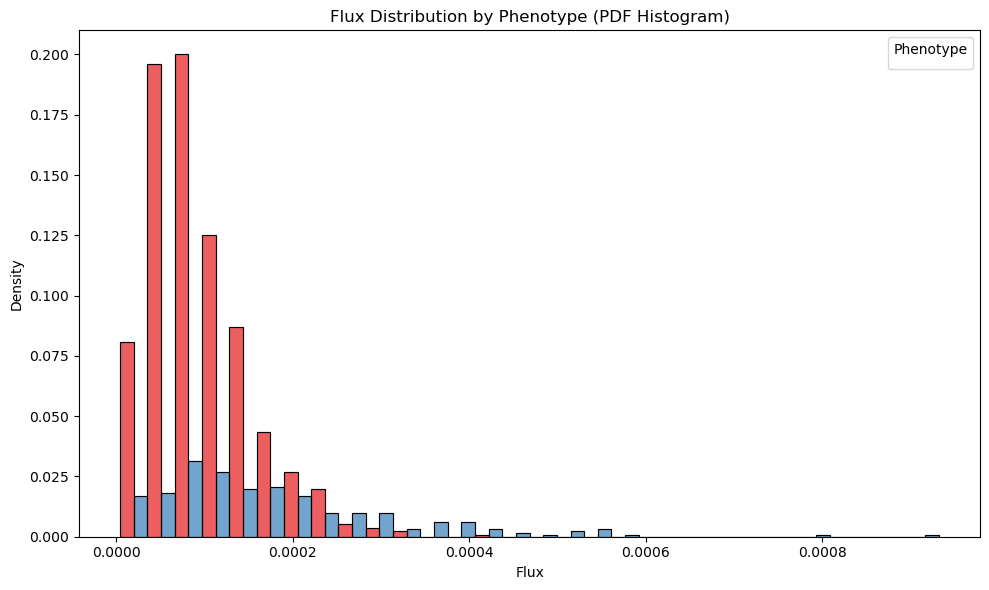

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

# Start with your original DataFrame
df_temp = df_proj_with_flux_PCA_cords

# Filter by 'ref_seg_id' <= 10
df_temp = df_temp[df_temp["ref_seg_id"] <= 10]

# Reset the index to avoid any potential duplicates
df_temp = df_temp.reset_index(drop=True)

# Filter for the two phenotypes
df_filtered = df_temp[df_temp["phenotype_2.0"].isin(["lmx1b30", "wt30"])]

# Plot the histogram using Seaborn with 'density' stat
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_filtered,
    x="flux",
    hue="phenotype_2.0",
    multiple="dodge",  # Places bars side-by-side for each phenotype
    stat="probability",    # Normalizes area under each histogram to 1
    bins=30,           # Adjust as needed for your data
    palette="Set1",
    alpha=0.7
)

# Customize the axes and title
plt.xlabel("Flux")
plt.ylabel("Density")  # Reflecting that we're plotting PDF (density)
plt.title("Flux Distribution by Phenotype (PDF Histogram)")
plt.legend(title="Phenotype")
plt.tight_layout()

plt.show()

(array([184., 366., 241., 139.,  57.,  31.,  12.,   5.,   1.,   1.]),
 array([6.42969443e-06, 4.70524623e-05, 8.76752302e-05, 1.28297998e-04,
        1.68920766e-04, 2.09543534e-04, 2.50166302e-04, 2.90789069e-04,
        3.31411837e-04, 3.72034605e-04, 4.12657373e-04]),
 <BarContainer object of 10 artists>)

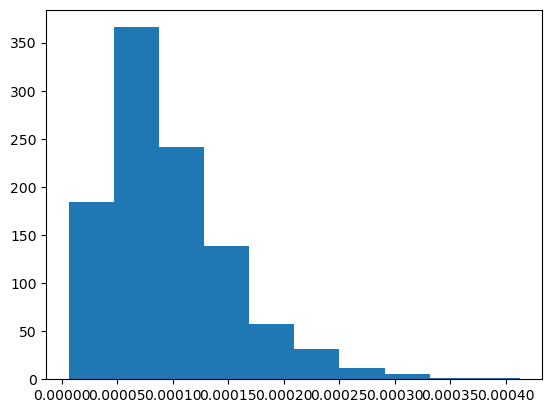

In [71]:
plt.hist(df_temp[df_temp["phenotype_2.0"]=="wt30"]["flux"])


In [ ]:
df_proj_with_flux_PCA_cords

In [36]:
# wt_projection_to_wt = wt_projection_to_wt.merge(
#     wt_pert_df[['snip_id', "experiment_time"]],
#     on='snip_id',
#     how='left'  # Use 'left' to keep all rows from df
# ).dropna()


wt_projection_to_wt

,snip_id,embryo_id,phenotype,predicted_stage_hpf,PCA_1,PCA_2,PCA_3,ref_seg_id,closest_on_spline_x,closest_on_spline_y,closest_on_spline_z,plane_point_x,plane_point_y,plane_point_z,distance_to_plane,distance_to_axis,hypotenuse,experiment_time
0,20230525_A03_e00_t0001,20230525_A03_e00,wt,15.105656,1.095991,1.833620,1.212556,4,1.158280,1.897078,1.223692,1.160600,1.844134,1.201844,0.066329,0.092133,0.113525,594.316650
1,20230525_A03_e00_t0002,20230525_A03_e00,wt,15.638449,0.755595,1.910756,1.106275,5,1.117051,1.954234,1.033301,1.108048,1.993250,1.032635,0.369393,0.038356,0.371379,3591.278076
2,20230525_A03_e00_t0003,20230525_A03_e00,wt,16.171827,0.811842,2.029998,0.887775,6,1.060323,2.013469,0.811298,1.049782,2.083147,0.829778,0.250607,0.087611,0.265480,6591.527710
3,20230525_A03_e00_t0004,20230525_A03_e00,wt,16.706109,0.702718,2.035258,0.682919,7,0.987488,2.072222,0.579584,0.978441,2.114923,0.576362,0.306144,0.077691,0.315848,9596.864624
4,20230525_A03_e00_t0005,20230525_A03_e00,wt,17.238502,0.536535,1.999427,0.693923,7,0.972565,2.081217,0.541678,0.958902,2.121462,0.530692,0.468967,0.040399,0.470704,12591.573975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48742,20241023_H06_e00_t0038,20241023_H06_e00,wt,50.238336,1.585095,-0.832325,-0.620377,43,1.720028,-0.819383,-0.412554,1.620371,-0.712137,-0.488513,0.181873,0.181966,0.257273,64127.787030
48743,20241023_H06_e00_t0039,20241023_H06_e00,wt,50.738937,1.663861,-0.790199,-0.704098,43,1.815305,-0.786610,-0.476455,1.702549,-0.658390,-0.559484,0.199458,0.193955,0.278212,65796.455422
48744,20241023_H06_e00_t0040,20241023_H06_e00,wt,51.239684,1.663431,-0.785894,-0.682730,43,1.806836,-0.789524,-0.470775,1.698577,-0.666148,-0.551351,0.181203,0.185270,0.259151,67465.614316
48745,20241023_H06_e00_t0041,20241023_H06_e00,wt,51.741783,1.735678,-0.743847,-0.748095,44,1.891160,-0.760576,-0.527372,1.737630,-0.661405,-0.646865,0.130567,0.272254,0.301944,69139.277532


In [37]:
# I want to measure the flux (delta space/ delta time) for a given embryo in for a given ref_seg_id. There are multiple points in a segment id (possibly or none in a given semgne t id) so hanle
# that possibilty. But for the points that are in you need to calulcate the average flux, note that you will have to have a minum of two points to calculate the flux. You can actually overcome this by just assigning the flux value to the ref_seg_id of the early time point (t0)
# colot each embryo_id by a specified column I will provide, call it "color_col" for now. You should additionally add a trend line (average of the values) for each color_col. Make the trend line a darker version of the same color while the others the non trend line is very opaque. 

In [29]:
# A) Points from "wt" itself
wt_pert_df = df_augmented[df_augmented["phenotype"] == "wt"]

wt_pert_df_30 = wt_pert_df[wt_pert_df["temperature"]==30]
wt_pert_df_22 = wt_pert_df[wt_pert_df["temperature"]==22]


wt_projection_to_wt_30 = project_points_onto_reference_spline(
    wt_pert_df_30,
    wt_splines_n_planes
)

wt_projection_to_wt_22 = project_points_onto_reference_spline(
    wt_pert_df_22,
    wt_splines_n_planes
)

KeyboardInterrupt: 